# Dolsek and Fajfar

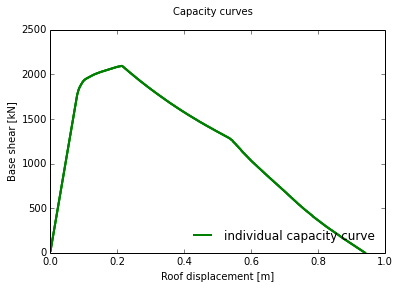

In [6]:
from rmtk.vulnerability.common import utils
%matplotlib inline 

input_type = 'Vb-dfloor'

capacity_curves_file = '../../../../../../rmtk_data/capacity_curves_Vb-dfloor.csv'

input_spectrum = '../../../../../../rmtk_data/FEMAP965spectrum.txt'
montecarlo_samples = 25

capacity_curves = utils.read_capacity_curves(capacity_curves_file)
utils.plot_capacity_curves(capacity_curves)
Sa_ratios = utils.get_spectral_ratios(capacity_curves,input_spectrum)

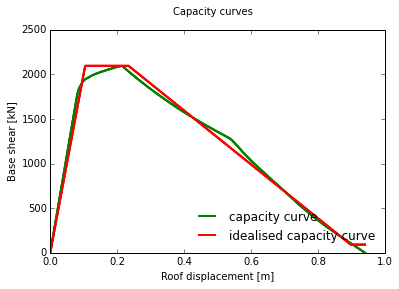

In [7]:
idealised_capacity = utils.idealisation('quadrilinear', capacity_curves)
utils.plot_idealised_capacity(idealised_capacity, capacity_curves, 'quadrilinear')

In [8]:
damage_model_file = '../../../../../../rmtk_data/damage_model_ISD.csv'
damage_model = utils.read_damage_model(damage_model_file)
print damage_model

{'dispersion': [[0.05, 0.05, 0.05, 0.05], [0.05, 0.05, 0.05, 0.05]], 'type_criteria': 'interstorey drift', 'distribution': ['normal', 'normal', 'normal', 'normal'], 'median': [[0.005, 0.01, 0.02, 0.05], [0.005, 0.01, 0.02, 0.05]], 'damage_states': ['Slight', 'Moderate', 'Extensive', 'Collapse']}


In [9]:
from rmtk.vulnerability.derivation_fragility.R_mu_T_no_dispersion.dolsek_fajfar import DF2004 

# constant accel-constant velocity  and constant velocity-constant
# displacement corner periods of a Newmark-Hall type spectrum
corner_periods = [0.5, 1.8]

fragility_model = DF2004.calculate_fragility(capacity_curves, idealised_capacity, damage_model, montecarlo_samples, Sa_ratios, corner_periods)
utils.plot_fragility(fragility_model,0.01,2)

mu(LS) =  [ 1.01944018  2.02678158  4.53093238  8.39693424]
medians= [ 0.12680143  0.24226913  0.46219755  0.79462096]
total dispersion= [ 0.04677496  0.20175977  0.30583027  0.37693382]
mu(LS) =  [ 1.01944018  2.02678158  4.53093238  8.39693424]
medians= [ 0.12680143  0.24226913  0.46219755  0.79462096]
total dispersion= [ 0.04677496  0.20175977  0.30583027  0.37693382]


AttributeError: 'module' object has no attribute 'plot_fragility'